# GENERALISED SIDELOBE CANCELLER

Esse Jupyter tem como objetivo implementar o algoritmo do GSC com algoritmo genético.

In [1]:
import librosa
import matplotlib.pyplot as plt
import math
import numpy as np
import time
import pandas as pd
from scipy.optimize import least_squares
from random import uniform
from os import listdir
from IPython.display import Audio

In [2]:
#DEFININDO ALGUNS PARÂMETROS PARA PLOTAR GRÁFICOS
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
params = {'figure.figsize': [7, 4], 
          'axes.labelsize': 12,
          'axes.titlesize':16, 
          'font.size': 12,
          'legend.fontsize': 12, 
          'xtick.labelsize': 10, 
          'ytick.labelsize': 10
         }

plt.rcParams.update(params)

## Definição de Funções

Abaixo, a já conhecida verificarDelay, que retorna o número de amostras de defasagem entre dois sinais.

In [3]:
def verificarDelay(sinalA, sinalB, maxDelay=25):
    
    # Verificando se os dois sinais tem o mesmo tamanho e se maxDelay é compatível
    if len(sinalA) != len(sinalB) or maxDelay >= len(sinalA)-1 :
        return False
    
    # Sei que o maior delay possível (em qtd de amostras) é maxDelay. Portanto, em cada iteração, 
    # a comparação entre os sinais para gerar a correlação se dará com arrays de tamanho 
    # len(sinal) - maxDelay
    tamanho = len(sinalA) - maxDelay
    
    # O delay será a qtd de amostras pra trás ou para frente que há
    # entre o sinal B em relação ao sinal A. Negativo significa que B está adiantado, 0 que não há
    # delay e positivo que está atrasado.
    delay = 0
    melhorCorrelacao = -1
    
    inicioA = 0
    fimA    = inicioA + tamanho
    inicioB = len(sinalB) - tamanho
    fimB    = inicioB + tamanho
    
    # Fazendo as iterações e calculando a correlação entre os sinais
    for i in range(-maxDelay, maxDelay+1):
        
        # Calculando a correlação da iteração atual
        corrAtual = np.corrcoef(sinalA[inicioA:fimA], sinalB[inicioB:fimB])[0][1]
        
        # Verificando se encontramos uma correlacao maior ainda para atualizar o delay
        if corrAtual > melhorCorrelacao:
            melhorCorrelacao = corrAtual
            delay = -i
            
        # Fazendo os indexes dos arrays da próxima iteração. De i = -maxDelay até 0, o Sinal A 
        # fica parado e o Sinal B vem vindo pra trás. A partir de i = 1 até maxDelay, o Sinal B
        # fica parado e o Sinal A vai embora.
        if i < 0:
            inicioB -= 1
            fimB     = inicioB + tamanho
        else:
            inicioA += 1
            fimA     = inicioA + tamanho
    
    # Retornando o delay
    return delay

Abaixo, a função beamforming, que receberá os sinais dos microfones e o delay entre cada um deles. A função então irá defasar os sinais de forma que o beamforming seja feito.

In [4]:
def beamforming(vetorSinais, vetorDelays):
    # O VETOR DE DELAYS TAMBEM PRECISA TER O DELAY00
    
    # SINAL QUE VAI CONTER TODOS OS OUTROS SOMADOS
    sinalFinal = np.zeros(len(vetorSinais[0]))
    
    # PARA CADA SINAL
    for index, sinalAtual in enumerate(vetorSinais):
        
        # DELAY ENTRE O SINAL ATUAL E O SINAL 0
        delayAtual = vetorDelays[index]
        
        # SE FOR POSITIVO, EU COMO UMA PARTE DO SINAL NO COMECO E PREENCHO COM ZEROS NO FINAL
        if delayAtual >= 0:
            vetorSinais[index] = np.concatenate((sinalAtual[delayAtual:], np.zeros(delayAtual)))
            
        # SE FOR NEGATIVO, EU COLOCO ZEROS NO COMECO E CORTO DO FINAL
        else:
            vetorSinais[index] = np.concatenate((np.zeros(-delayAtual), sinalAtual[:delayAtual]))
            
        # POR ULTIMO, EU SOMO O SINAL ATUAL NO SINAL FINAL
        sinalFinal += sinalAtual
            
    # NO FINAL
    return sinalFinal, vetorSinais

Função para gerar uma Blocking Matrix

Dimensão da matriz: qtdMicrofones-1 x qtdMicrofones

https://drive.google.com/drive/folders/1d_B72P3emyTU_1Z1_3ry5KqWh5PqaJdO 2001_Book_MicrophoneArrays Página 34

In [5]:
def gerarBlockingMatrix(qtdMics):
    
    # INICIANDO A MATRIZ COM ZEROS
    blockingMatrix = np.zeros((qtdMics-1, qtdMics))
    
    for cont, linha in enumerate(blockingMatrix):
        linha[cont]   = 1
        linha[cont+1] = -1
    
    return blockingMatrix

Função para calcular a energia de um sinal:

In [6]:
def energiaSinal(sinal):
    return sum(sinal**2)

## Aplicando o GSC

### Importando os sinais dos microfones

A gravação que será utilizada nesse Jupyter é a segunda. Os áudios dos microfones estão defasados para simular um array de microfones e o ruído será adicionado à parte.

In [7]:
diretorio = '/home/dimi/Programming/IC2019/DOA/Gravacoes/Simulacoes/Gravacao2/'

sinalMic0, freqAmostragem = librosa.load(diretorio + 'mic-01.wav', sr=None, mono=True)
sinalMic1, freqAmostragem = librosa.load(diretorio + 'mic-02.wav', sr=None, mono=True)
sinalMic2, freqAmostragem = librosa.load(diretorio + 'mic-03.wav', sr=None, mono=True)
sinalMic3, freqAmostragem = librosa.load(diretorio + 'mic-04.wav', sr=None, mono=True)
sinalMic4, freqAmostragem = librosa.load(diretorio + 'mic-05.wav', sr=None, mono=True)
sinalMic5, freqAmostragem = librosa.load(diretorio + 'mic-06.wav', sr=None, mono=True)
sinalMic6, freqAmostragem = librosa.load(diretorio + 'mic-07.wav', sr=None, mono=True)
sinalMic7, freqAmostragem = librosa.load(diretorio + 'mic-08.wav', sr=None, mono=True)

arraySinaisOriginais = np.array([
    sinalMic0,
    sinalMic1,
    sinalMic2,
    sinalMic3,
    sinalMic4,
    sinalMic5,
    sinalMic6,
    sinalMic7
])

Verificando como é o sinal original, sem ruído:

In [8]:
i = 0
print("Exemplo de um dos sinais dos microfones originais SEM ruído")
Audio(data=arraySinaisOriginais[i], rate=freqAmostragem)

Exemplo de um dos sinais dos microfones originais SEM ruído


### Verificando o delay entre os microfones

Agora, para mandar para a função que fará o beamforming, preciso dos delays entre cada microfone. Para a função beamforming funcionar, TAMBÉM PRECISO DO DELAY ENTRE O MICROFONE 0 E O MICROFONE 0, por isso aquele 0 no começo do array:

In [9]:
arrayDelays = np.array([
    0,
    verificarDelay(arraySinaisOriginais[0], arraySinaisOriginais[1]),
    verificarDelay(arraySinaisOriginais[0], arraySinaisOriginais[2]),
    verificarDelay(arraySinaisOriginais[0], arraySinaisOriginais[3]),
    verificarDelay(arraySinaisOriginais[0], arraySinaisOriginais[4]),
    verificarDelay(arraySinaisOriginais[0], arraySinaisOriginais[5]),
    verificarDelay(arraySinaisOriginais[0], arraySinaisOriginais[6]),
    verificarDelay(arraySinaisOriginais[0], arraySinaisOriginais[7])
])

print(arrayDelays)

[  0 -10  10 -12  -3   4  14  -1]


### Adicionando o ruído

In [10]:
ruidoOriginal, freqAmostragem = librosa.load(diretorio + 'ruido.wav', sr=None, mono=True)

for mic in arraySinaisOriginais:
    mic += ruidoOriginal

Ouvindo o mesmo microfone, agora com ruído:

In [11]:
i = 0
print("Exemplo de um dos sinais dos microfones originais COM ruído")
Audio(data=arraySinaisOriginais[i], rate=freqAmostragem)

Exemplo de um dos sinais dos microfones originais COM ruído


### Criando o sinal original: Soma de todos os microfones com ruído

Antes de fazer o Beamforming, Blocking Matrix e tal, vou criar o somaSinaisOriginais, que vai ser a soma de todos os microfones do jeito que eles vieram mesmo.

In [12]:
somaSinaisOriginais = np.sum(arraySinaisOriginais, axis=0)
Audio(data=somaSinaisOriginais, rate=freqAmostragem)

### Visualizando os dados de entrada para o GSC

Os dados de entrada necessários para compor o algoritmo GSC são os sinais dos microfones e os delays entre os microfones.

In [13]:
i = 0

print("O sinal do microfone", i, "possui o seguinte shape:\n", arraySinaisOriginais[i].shape)
print("\n\nSinal do microfone " + str(i) + ":\n", arraySinaisOriginais[i])
print("\n\nEm seguida, o array de delays:\n", arrayDelays)

O sinal do microfone 0 possui o seguinte shape:
 (85860,)


Sinal do microfone 0:
 [-0.01751709 -0.01519775 -0.0145874  ...  0.01239014  0.01785278
  0.01171875]


Em seguida, o array de delays:
 [  0 -10  10 -12  -3   4  14  -1]


### Aplicando o Beamforming

Olhando para os sinais antes do Beamforming:

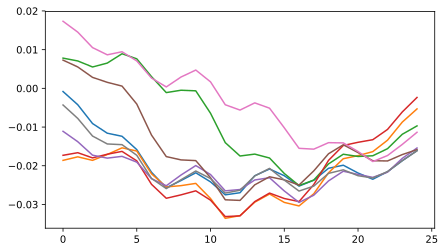

In [14]:
inicio = 50000
fim    = 50025

plt.plot(arraySinaisOriginais[0][inicio:fim])
plt.plot(arraySinaisOriginais[1][inicio:fim])
plt.plot(arraySinaisOriginais[2][inicio:fim])
plt.plot(arraySinaisOriginais[3][inicio:fim])
plt.plot(arraySinaisOriginais[4][inicio:fim])
plt.plot(arraySinaisOriginais[5][inicio:fim])
plt.plot(arraySinaisOriginais[6][inicio:fim])
plt.plot(arraySinaisOriginais[7][inicio:fim])

plt.show()

Agora posso criar uma sinal com a soma de todos os outros defasados:

In [15]:
# APLICANDO O BEAMFORMING
sinalBF, arraySinaisBF = beamforming(arraySinaisOriginais, arrayDelays)

# POR ALGUM MOTIVO O PYTHON ESTA MUDANDO OS SINAIS ORIGINAIS TAMBEM
# POR ISSO, VOU CRIAR O ARRAY DE SINAIS ORIGINAIS DE NOVO
arraySinaisOriginais = np.array([
    sinalMic0,
    sinalMic1,
    sinalMic2,
    sinalMic3,
    sinalMic4,
    sinalMic5,
    sinalMic6,
    sinalMic7
])

print("Áudio após a aplicação do Beamforming:")
Audio(data=sinalBF, rate=freqAmostragem)

Áudio após a aplicação do Beamforming:


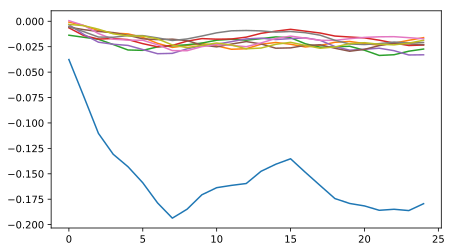

In [16]:
inicio = 50000
fim    = 50025

plt.plot(sinalBF[inicio:fim])
plt.plot(arraySinaisBF[0][inicio:fim])
plt.plot(arraySinaisBF[1][inicio:fim])
plt.plot(arraySinaisBF[2][inicio:fim])
plt.plot(arraySinaisBF[3][inicio:fim])
plt.plot(arraySinaisBF[4][inicio:fim])
plt.plot(arraySinaisBF[5][inicio:fim])
plt.plot(arraySinaisBF[6][inicio:fim])
plt.plot(arraySinaisBF[7][inicio:fim])

plt.show()

### Blocking Matrix

A próxima parte é gerar uma Blocking Matrix

In [17]:
blockingMatrix = gerarBlockingMatrix(qtdMics=8)
print(blockingMatrix)

[[ 1. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -1.]]


Agora, posso fazer a multiplicaçao BM x Sinais. Essa multiplicação vai resultar em um sinal a menos.

In [18]:
arraySinaisBM = np.matmul(blockingMatrix, arraySinaisOriginais)
print("O array de sinais após a Blocking Matrix tem shape:", arraySinaisBM.shape)
print("\nExemplo de sinal após a multiplicação da Blocking Matrix:")

i = 4
Audio(data=arraySinaisBM[i], rate=freqAmostragem)

O array de sinais após a Blocking Matrix tem shape: (7, 85860)

Exemplo de sinal após a multiplicação da Blocking Matrix:


### Teste manual (sem filtragem adaptativa)

Vou fazer a soma dos sinais que restaram após a Blocking Matrix e depois vou multiplicá-los por um fator. O resultado será subtraído do sinal beamformado.

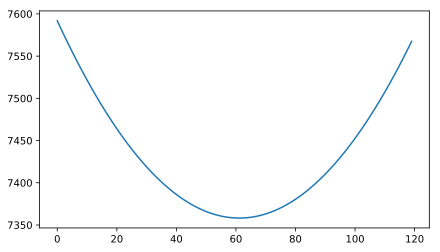

O fator que minimizará a energia do sinal final é: 4.2000000000000055


In [19]:
energiasFatores = [9e9]
melhorFator     = 0
somaSinaisAposBM = np.sum(arraySinaisBM, axis=0)

for i, fatorAtual in enumerate(np.arange(-2, 10, 0.1)):
    energiasFatores.append(energiaSinal(sinalBF - fatorAtual*somaSinaisAposBM))
    
    if energiasFatores[i] < energiasFatores[i-1]:
        melhorFator = fatorAtual

plt.plot(energiasFatores[1:])
plt.show()

print("O fator que minimizará a energia do sinal final é:", melhorFator)

In [20]:
fator      = 4.1
sinalFinal = sinalBF - fator*somaSinaisAposBM

print("Energia do sinal original:\t\t", energiaSinal(sinalBF))
print("Energia do sinal após a subtração:\t", energiaSinal(sinalFinal))

Energia do sinal original:		 7463.9722822783515
Energia do sinal após a subtração:	 7358.201651551023


In [21]:
print("Áudio Beamformado:")
Audio(data=sinalBF, rate=freqAmostragem)

Áudio Beamformado:


In [22]:
print("Áudio da soma dos sinais após a Blocking Matriz (ruído):")
Audio(data=somaSinaisAposBM, rate=freqAmostragem)

Áudio da soma dos sinais após a Blocking Matriz (ruído):


In [23]:
print("Áudio após a subtração do ruído:")
Audio(data=sinalFinal, rate=freqAmostragem)

Áudio após a subtração do ruído:


# Aplicando o GSC com Algoritmo Genético

Até agora, tenho os seguintes sinais:

__somaSinaisOriginais:__ Soma de cada um dos microfones do jeito que eles vieram, sem fazer beamforming nem nada;

__arraySinaisBF:__ Um array com os sinais originais defasados. Somar os sinais desse array produz o sinal beamformado;

__arraySinaisBM:__ Um array com os sinais que restaram após a Blocking Matrix.

Vou começar a escrever as funções para o algoritmo genético.

### Definição de funções para o algoritmo genético

#### Função para criar um indivíduo aleatório

Cada indivíduo será um array com N-1 posições, sendo N o número de microfones. Isto porque depois da Blocking Matrix, sobra um sinal a menos.

Cada posição será o peso multiplicativo do respectivo sinal após a blocking matrix. Esses pesos serão aleatórios para essa função, afinal, ela só será usada na hora de criar a população inicial. Depois, haverá o crossover.

Sinal Final = Sinal Beamformado - (peso1 * sinal1BM + peso2 * sinal2BM + ... + pesoN-1 * sinalN-1BM)

In [24]:
def criarNovoIndividuo(qtdMics):
    
    individuo = []
    
    for i in range(qtdMics-1):
        individuo.append(uniform(0.0, 15.0))
        
    return np.array(individuo)

In [25]:
individuo = criarNovoIndividuo(8)
print(individuo)

[10.41946009  5.45063454  7.36147283  8.62233479  2.53228348  9.24732503
  2.87402656]


#### Função para criar a população inicial

In [26]:
def criarPopulacaoInicial(qtdMics, qtdIndividuos=25):
    
    populacaoInicial = []
    
    for i in range(qtdIndividuos):
        populacaoInicial.append(criarNovoIndividuo(qtdMics))
        
    return np.array(populacaoInicial)

In [27]:
populacao = criarPopulacaoInicial(8, 3)
print(populacao)

[[10.33932624  0.67267726 13.78599901  0.09817253  1.9417304   2.00092672
   9.03715918]
 [ 7.73682772  3.77646305  6.4465253   8.40774455  8.22348919  8.53167157
  11.89518769]
 [ 1.83141575  3.29231456  3.95453283 10.99303296 12.84101895  8.10281469
   5.92741579]]


#### Função Fitness

O Fitness de cada indivíduo será a energia do sinal após a subtração dos sinais da Blocking Matrix sobre o sinal beamformado.

In [28]:
def fitness(individuo, sinalBF, arraySinaisBM):
    
    sinalRuidos = 0
    
    # SOMANDO CADA UM DOS SINAIS DA BLOCKING MATRIX COM SEU DEVIDO PESO
    for index, peso in enumerate(individuo):
        sinalRuidos += peso * arraySinaisBM[index]
        
    sinalFinal = sinalBF - sinalRuidos
    
    return energiaSinal(sinalFinal)

In [29]:
print(energiaSinal(sinalBF), "\n")
print(fitness(populacao[0], sinalBF, arraySinaisBM))

7463.9722822783515 

72284.82781391908


#### Função para calcular o fitness de toda a população

Posteriormente, será necessário ordenar todos os indivíduos na ordem de melhor para o pior fitness para que seja possível selecionar os melhores para reprodução. Ela recebe a população atual e retorna um vetor contendo o respectivo Fitness de cada indivíduo.

In [30]:
# Função que retorna um vetor contendo o fitness de cada individuo na população.
def calcularFitnessPopulacao(populacao, sinalBF, arraySinaisBM):
    
    vetorFitness = []
    
    for individuoAtual in populacao:
        vetorFitness.append(fitness(individuoAtual, sinalBF, arraySinaisBM))
        
    return np.array(vetorFitness)

In [31]:
vetorFitness = calcularFitnessPopulacao(populacao, sinalBF, arraySinaisBM)
print(vetorFitness)

[72284.82781392 13968.80103771 16864.70964492]


#### Função para realizar mutação

Primeiro gero um número aleatório para testar a probabilidade de haver mutação. Caso haja mutação, seleciono aleatoriamente um gene e faço ele ter um novo valor aleatório.

In [32]:
def realizarMutação(individuo, probabilidadeMutacao):
    
    # ROLANDO O DADO PARA VER SE ELE VAI SOFRER MUTAÇÃO OU NÃO
    if uniform(0,1) <= probabilidadeMutacao:
        
        # SE SIM, VOU ESCOLHER UM GENE ALEATORIAMENTE PARA SOFRER A MUTAÇÃO
        geneMutacao = int(uniform(0, len(individuo)))
        individuo[geneMutacao] = uniform(0.0, 15.0)
        
    return individuo

In [33]:
index = 0

print(populacao[index])
populacao[index] = realizarMutação(populacao[index], 1)
print(populacao[index])

[10.33932624  0.67267726 13.78599901  0.09817253  1.9417304   2.00092672
  9.03715918]
[10.33932624  0.67267726 13.78599901  0.09817253  1.9417304   2.00092672
  0.18318525]


#### Função Crossover

A reprodução dos indivíduos consistirá na média de cada gene.

In [34]:
def crossover(individuoPai, individuoMae, probabilidadeMutacao):
    individuoFilho = (individuoPai + individuoMae)/2
    individuoFilho = realizarMutação(individuoFilho, probabilidadeMutacao)
    return individuoFilho

In [35]:
pai   = populacao[0]
mae   = populacao[1]
filho = crossover(pai, mae, 0)

print(pai, "\n", mae, "\n", filho)

[10.33932624  0.67267726 13.78599901  0.09817253  1.9417304   2.00092672
  0.18318525] 
 [ 7.73682772  3.77646305  6.4465253   8.40774455  8.22348919  8.53167157
 11.89518769] 
 [ 9.03807698  2.22457015 10.11626216  4.25295854  5.0826098   5.26629915
  6.03918647]


#### Função para ordenar os individuos de acordo com o fitness

A seleção dos melhores indivíduos da população para reprodução depende de que o vetor **populacao** esteja devidamente ordenado do melhor fitness para o pior. A função abaixo ordena o vetor **popualacao** de acordo com o fitness de cada indivíduo. É importante lembrar que **vetorFitness** também será reorganizado para manter o arranjo **indivíduos <-> fitness**.

In [36]:
def ordenarIndividuos(populacao, vetorFitness):
    
    populacao.tolist()
    vetorFitness.tolist()
    
    for i in range(0, len(vetorFitness)):
        for j in range(i+1, len(vetorFitness)):
            if vetorFitness[j] < vetorFitness[i]:
                vetorFitness[i], vetorFitness[j] = vetorFitness[j], vetorFitness[i]
                populacao[[i, j]] = populacao[[j, i]]
            
    return np.array(populacao), np.array(vetorFitness)

In [37]:
populacao    = criarPopulacaoInicial(8, 5)
vetorFitness = calcularFitnessPopulacao(populacao, sinalBF, arraySinaisBM) 

for i, individuoAtual in enumerate(populacao):
    print("[" + str(individuoAtual[0]) + "]", "\t->\t", vetorFitness[i])
    
populacao, vetorFitness = ordenarIndividuos(populacao, vetorFitness)
print("\n")
    
for i, individuoAtual in enumerate(populacao):
    print("[" + str(individuoAtual[0]) + "]", "\t->\t", vetorFitness[i])

[10.031679489647562] 	->	 14728.68170568383
[5.1546101607884935] 	->	 25209.88407778655
[13.968678635373927] 	->	 8326.332006620021
[8.667157024646945] 	->	 10795.8124496635
[2.6891861197838782] 	->	 46017.541569008376


[13.968678635373927] 	->	 8326.332006620021
[8.667157024646945] 	->	 10795.8124496635
[10.031679489647562] 	->	 14728.68170568383
[5.1546101607884935] 	->	 25209.88407778655
[2.6891861197838782] 	->	 46017.541569008376


#### Funções para selecionar os indivíduos pai e mãe para reprodução

A primeira função é responsável por selecionar o **index** do indivíduo que será selecionado de acordo com as probabilidades: 0 -> 50%; 1 -> 25%; 2 -> 12,5% e assim sucessivamente.

A segunda função usa a primeira para selecionar os indivíduos pai e mãe, e garante que eles sejam diferentes.

In [38]:
def selecionarIndexParaReproducao():
    limite = 0.6
    probabilidade = uniform(0,1)
    i = 0
    
    while 1 == 1:
        if probabilidade >= limite:
            break
        else:
            i += 1
            limite = limite/1.5
            
    return i

In [39]:
sorteios = []
for a in range(100000):
    sorteios.append(selecionarIndexParaReproducao())

print("Index\t Percentual de ocorrências")
for i in range(10):
    count = sorteios.count(i)
    print(i, "\t", count/100000)

Index	 Percentual de ocorrências
0 	 0.40229
1 	 0.19932
2 	 0.13366
3 	 0.08736
4 	 0.05889
5 	 0.03903
6 	 0.02666
7 	 0.0176
8 	 0.01134
9 	 0.00773


In [40]:
def selecionarIndexPaiMae(tamanhoPopulacao):
    
    # SELECIONO UM INDEX PARA O PAI E VERIFICO SE E VALIDO
    indexPai = selecionarIndexParaReproducao()

    while (indexPai > (tamanhoPopulacao - 1)):
        indexPai = selecionarIndexParaReproducao()
    
    # AGORA FACO A MESMA COISA PARA A MAE, LEMBRANDO QUE NAO PODE SER UM INDEX IGUAL AO DO PAI
    indexMae = selecionarIndexParaReproducao()
        
    while (indexMae > (tamanhoPopulacao - 1)) or indexMae == indexPai:
        indexMae = selecionarIndexParaReproducao()

    # AGORA POSSO RETORNAR OS INDEXES
    return indexPai, indexMae

In [41]:
pai, mae = selecionarIndexPaiMae(5)
print(pai, mae)

1 0


#### Função principal que une todas as outras

Essa função será responsável por criar a população inicial, realizar os primeiros cruzamentos e progredir as gerações.

In [42]:
def rodarAlgoritmoGenetico(qtdMics, tamanhoPopulacao, qtdMaxIteracoes, qtdNovosIndividuos, probabilidadeMutacao, sinalBF, arraySinaisBM):
    
    # Vetores que serão usados para plotar dados obtidos
    vetorMediaFitness = []
    vetorMaxFitness = []
    vetorMinFitness = []

    # Criando a população inicial
    populacao = criarPopulacaoInicial(qtdMics, tamanhoPopulacao)

    for i in range(0, qtdMaxIteracoes):
        # Para cada iteração eu calculo o fitness dos indivíduos e ordeno-os de acordo com esse valor
        vetorFitness = calcularFitnessPopulacao(populacao, sinalBF, arraySinaisBM)
        populacao, vetorFitness = ordenarIndividuos(populacao, vetorFitness)

        # Guardando dados sobre a iteração atual para plotar depois
        vetorMediaFitness.append(np.mean(vetorFitness))
        vetorMaxFitness.append(np.amax(vetorFitness))
        vetorMinFitness.append(np.amin(vetorFitness))

        # Fazendo a reprodução para criar a geração futura
        novaGeracao = []
        for j in range(qtdNovosIndividuos):

            # Indexes da população para escolher os reprodutores
            indexPai, indexMae = selecionarIndexPaiMae(len(populacao)) 

            # Gerando os filhos (a mutação acontece dentro da função crossover, não é necessário realizar a 
            # mutação nessa célula)
            filho = crossover(populacao[indexPai], populacao[indexMae], probabilidadeMutacao)

            # Colocando os filhos na nova geração
            novaGeracao.append(filho)

        # Aqui, irei substituir os piores individuos da geração anterior pelos novos filhos gerados
        # dessa forma, alguns indivíduos da geração anterior irão permanecer para a próxima geração
        populacao = populacao[:len(populacao)-len(novaGeracao)]
        populacao = np.concatenate((populacao, np.array(novaGeracao)), axis=0)
        
    # Agora que acabaram as gerações, vou colocar os indivíduos em ordem pra retornar o melhor
    vetorFitness = calcularFitnessPopulacao(populacao, sinalBF, arraySinaisBM)
    populacao, vetorFitness = ordenarIndividuos(populacao, vetorFitness)
    
    melhorIndividuoFinal = populacao[0]
    melhorFitnessFinal   = vetorFitness[0] 
    
    return vetorMinFitness, vetorMediaFitness, vetorMaxFitness, melhorIndividuoFinal, melhorFitnessFinal

## Finalmente rodando o algoritmo genético para o GSC

In [43]:
qtdMics = 8
tamanhoPopulacao = 50
qtdNovosIndividuos = 15
probabilidadeMutacao = 0.07
qtdMaxIteracoes = 15

tempoInicial = time.time()
vetorMinFitness, vetorMediaFitness, vetorMaxFitness, melhorIndividuoFinal, melhorFitnessFinal = rodarAlgoritmoGenetico(qtdMics, tamanhoPopulacao, qtdMaxIteracoes, qtdNovosIndividuos, probabilidadeMutacao, sinalBF, arraySinaisBM)
tempoFinal   = time.time()

tempoTotalAG = tempoFinal - tempoInicial

print(tempoTotalAG)

8.244171380996704


Text(0, 0.5, 'Fitness')

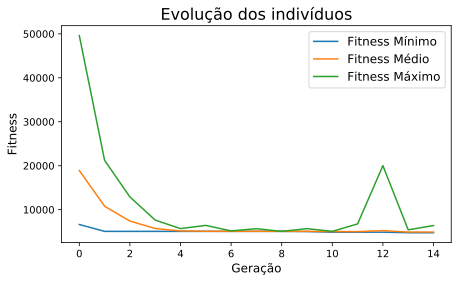

In [44]:
plt.plot(vetorMinFitness, label="Fitness Mínimo")
plt.plot(vetorMediaFitness, label="Fitness Médio")
plt.plot(vetorMaxFitness, label="Fitness Máximo")
plt.legend()
plt.title("Evolução dos indivíduos")
plt.xlabel("Geração")
plt.ylabel("Fitness")

#### Construindo o sinal final a partir dos pesos encontrados

In [45]:
# CONSTRUINDO O SINAL FINAL
sinalRuidos = 0
for index, peso in enumerate(melhorIndividuoFinal):
    sinalRuidos += peso * arraySinaisBM[index]
sinalFinalAG = sinalBF - sinalRuidos

# VERIFICANDO A MELHORA NA ENERGIA DO SINAL
energiaInicial      = energiaSinal(sinalBF)
energiaFinalAG      = energiaSinal(sinalFinalAG)
reducaoPercentualAG = 1 - energiaFinalAG/energiaInicial

print("Energia inicial:\t", energiaInicial)
print("Energia final:\t\t", energiaFinalAG)
print("Redução percentual:\t", reducaoPercentualAG)

Energia inicial:	 7463.9722822783515
Energia final:		 4751.343350637099
Redução percentual:	 0.3634296630604893


### Ouvindo o resultado

In [46]:
print("Áudio original sem beamforming:")
Audio(data=somaSinaisOriginais, rate=freqAmostragem)

Áudio original sem beamforming:


In [47]:
print("Áudio após o beamforming:")
Audio(data=sinalBF, rate=freqAmostragem)

Áudio após o beamforming:


In [48]:
print("Áudio após o GSC completo:")
Audio(data=sinalFinalAG, rate=freqAmostragem)

Áudio após o GSC completo:


#### Salvando os áudios como WAV

Antes de fazer isso, vou dividir todos os áudios por 8, pois os microfones foram somados e agora esses sinais estão muito altos.

In [49]:
# somaSinaisOriginais = somaSinaisOriginais/8
# sinalBF             = sinalBF/8
# sinalFinal          = sinalFinal/8

#librosa.output.write_wav('sinalOriginal.wav', somaSinaisOriginais, freqAmostragem)
#librosa.output.write_wav('sinalBeamformado.wav', sinalBF, freqAmostragem)
#librosa.output.write_wav('sinalFinal.wav', sinalFinal, freqAmostragem)

In [50]:
print(energiaSinal(somaSinaisOriginais))
print(energiaSinal(sinalBF))
print(energiaSinal(sinalFinalAG))

7130.918664532714
7463.9722822783515
4751.343350637099


## Utilizando Mínimos Quadrados

Vamos minimizar a função abaixo. Ela recebe o array de pesos e retorna a energia do sinal após o GSC.

In [51]:
def funEnergiaSinalFinal(arrayPesos):
    
    sinalRuidos = 0
    for index, peso in enumerate(arrayPesos):
        sinalRuidos += peso * arraySinaisBM[index]
    
    sinalFinalLMS = sinalBF - sinalRuidos
    
    return energiaSinal(sinalFinalLMS)

A célula abaixo vai rodar o LMS. Temos que dar um chute inicial para os pesos e dizer quais são os limites inferiores e superiores para cada dimensão. O objeto **res** tem vários aributos, sendo **x** o resultado.

In [52]:
chuteInicial  = [5, 5, 5, 5, 5, 5, 5]
limites       = [[0, 0, 0, 0, 0, 0, 0],
                 [15, 15, 15, 15, 15, 15, 15]]

tempoInicial  = time.time()
resLMS        = least_squares(fun=funEnergiaSinalFinal, x0=chuteInicial, bounds=limites)
tempoFinal    = time.time()

tempoTotalLMS = tempoFinal - tempoInicial
print(tempoTotalLMS)

60.151703119277954


In [53]:
print("Least Mean Squares\t Algoritmo Genético\t Diferença")
for i in range(len(resLMS.x)):
    print(resLMS.x[i], "\t", melhorIndividuoFinal[i], "\t", np.abs(resLMS.x[i]-melhorIndividuoFinal[i]))

Least Mean Squares	 Algoritmo Genético	 Diferença
8.547404708929873 	 11.33916133739609 	 2.791756628466217
8.022812004689358 	 11.525976091302164 	 3.5031640866128058
7.0104102865305435 	 10.008345829102298 	 2.9979355425717547
3.430881808809841 	 5.218576300834883 	 1.7876944920250417
3.3674706834980843 	 7.655639986707417 	 4.288169303209333
3.558840731228203 	 8.139949287064933 	 4.58110855583673
0.2549393342759103 	 4.6300362902999606 	 4.37509695602405


In [54]:
# CONSTRUINDO O SINAL FINAL
sinalRuidos = 0
for index, peso in enumerate(resLMS.x):
    sinalRuidos += peso * arraySinaisBM[index]
sinalFinalLMS = sinalBF - sinalRuidos

# VERIFICANDO A MELHORA NA ENERGIA DO SINAL
energiaInicial       = energiaSinal(sinalBF)
energiaFinalLMS      = energiaSinal(sinalFinalLMS)
reducaoPercentualLMS = 1 - energiaFinalLMS/energiaInicial

print("Energia inicial:\t", energiaInicial)
print("Energia final:\t\t", energiaFinalLMS)
print("Redução percentual:\t", reducaoPercentualLMS)

Energia inicial:	 7463.9722822783515
Energia final:		 4597.239378239861
Redução percentual:	 0.38407603828392434


### Ouvindo o resultado

In [55]:
print("Áudio original sem beamforming:")
Audio(data=somaSinaisOriginais, rate=freqAmostragem)

Áudio original sem beamforming:


In [56]:
print("Áudio após o beamforming:")
Audio(data=sinalBF, rate=freqAmostragem)

Áudio após o beamforming:


In [57]:
print("Áudio após o GSC completo:")
Audio(data=sinalFinalLMS, rate=freqAmostragem)

Áudio após o GSC completo:


### Comparando com o algoritmo genético

In [58]:
print("Redução percentual da energia com AG:", reducaoPercentualAG)
print("Redução percentual da energia com LMS:", reducaoPercentualLMS)

print("Tempo do AG:", tempoTotalAG)
print("Tempo do LMS:", tempoTotalLMS)

Redução percentual da energia com AG: 0.3634296630604893
Redução percentual da energia com LMS: 0.38407603828392434
Tempo do AG: 8.244171380996704
Tempo do LMS: 60.151703119277954


In [59]:
print("Áudio final com AG:")
Audio(data=sinalFinalAG, rate=freqAmostragem)

Áudio final com AG:


In [60]:
print("Áudio final com LMS:")
Audio(data=sinalFinalLMS, rate=freqAmostragem)

Áudio final com LMS:


## Usando Differential Evolution

In [61]:
from scipy.optimize import differential_evolution

In [62]:
limites       = [(0, 15),(0, 15),(0, 15),(0, 15),(0, 15),(0, 15),(0, 15)]

tempoInicial  = time.time()
resDE         = differential_evolution(funEnergiaSinalFinal, bounds=limites, updating='deferred', workers=4)
tempoFinal    = time.time()

tempoTotalDE = tempoFinal - tempoInicial
print(tempoTotalDE)

80.8125832080841


In [63]:
print("Least Mean Squares\t DE\t\t\t Diferença")
for i in range(len(resDE.x)):
    print(resLMS.x[i], "\t", resDE.x[i], "\t", np.abs(resLMS.x[i]-resDE.x[i]))

Least Mean Squares	 DE			 Diferença
8.547404708929873 	 8.328189902509104 	 0.2192148064207693
8.022812004689358 	 7.7993931952249875 	 0.22341880946437076
7.0104102865305435 	 6.771197345638712 	 0.23921294089183132
3.430881808809841 	 3.1926306384016296 	 0.23825117040821153
3.3674706834980843 	 3.056001161398147 	 0.3114695220999373
3.558840731228203 	 3.2893093038061902 	 0.26953142742201264
0.2549393342759103 	 0.0 	 0.2549393342759103


In [64]:
# CONSTRUINDO O SINAL FINAL
sinalRuidos = 0
for index, peso in enumerate(resDE.x):
    sinalRuidos += peso * arraySinaisBM[index]
sinalFinalDE = sinalBF - sinalRuidos

# VERIFICANDO A MELHORA NA ENERGIA DO SINAL
energiaInicial       = energiaSinal(sinalBF)
energiaFinalDE       = energiaSinal(sinalFinalDE)
reducaoPercentualDE  = 1 - energiaFinalDE/energiaInicial

print("Energia inicial:\t", energiaInicial)
print("Energia final:\t\t", energiaFinalDE)
print("Redução percentual:\t", reducaoPercentualDE)

Energia inicial:	 7463.9722822783515
Energia final:		 4594.642979557064
Redução percentual:	 0.38442389577650404


In [65]:
print("Redução percentual da energia com AG:", reducaoPercentualAG)
print("Redução percentual da energia com LMS:", reducaoPercentualLMS)
print("Redução percentual da energia com DE:", reducaoPercentualDE)

print("\nTempo do AG:", tempoTotalAG)
print("Tempo do LMS:", tempoTotalLMS)
print("Tempo do DE:", tempoTotalDE)

Redução percentual da energia com AG: 0.3634296630604893
Redução percentual da energia com LMS: 0.38407603828392434
Redução percentual da energia com DE: 0.38442389577650404

Tempo do AG: 8.244171380996704
Tempo do LMS: 60.151703119277954
Tempo do DE: 80.8125832080841
